# Performing Tritium Breeding Ratio (TBR) simulations

This python notebook allows users to perform neutronics simulations to tally tritium production.

This example uses a simple sphere model with a breeder material and a tritium production tally.

First import OpenMC and configure the nuclear data path

In [1]:
import openmc
from pathlib import Path
# Setting the cross section path to the correct location in the docker image.
# If you are running this outside the docker image you will have to change this path to your local cross section path.
openmc.config['cross_sections'] = Path.home() / 'nuclear_data' / 'cross_sections.xml'

This first code block makes the geometry, materials and settings for the neutronics model.

In [2]:
# MATERIALS

breeder_material = openmc.Material()  # lithium lead chemical equation is Pb84.2Li15.8
breeder_material.add_element('Pb', 84.2, percent_type='ao')
# 50% enriched lithium 6, natural percentage of lithium 6 is just 7% 
breeder_material.add_element('Li', 15.8, percent_type='ao', enrichment=50.0, enrichment_target='Li6', enrichment_type='ao')
# we set density using atoms per b-cm units as then when the enrichment changes the dnesity in these units stays the same.
# It equates to around 11 g/cm3
breeder_material.set_density('atom/b-cm', 3.2720171e-2)


steel = openmc.Material()
steel.set_density('g/cm3', 7.75)
steel.add_element('Fe', 0.95, percent_type='wo')
steel.add_element('C', 0.05, percent_type='wo')

my_materials = openmc.Materials([breeder_material, steel])


# GEOMETRY

# surfaces
vessel_inner = openmc.Sphere(r=500)
first_wall_outer_surface = openmc.Sphere(r=510)
breeder_blanket_outer_surface = openmc.Sphere(r=610, boundary_type='vacuum')


# cells
inner_vessel_region = -vessel_inner
inner_vessel_cell = openmc.Cell(region=inner_vessel_region)

first_wall_region = -first_wall_outer_surface & +vessel_inner
first_wall_cell = openmc.Cell(region=first_wall_region)
first_wall_cell.fill = steel

breeder_blanket_region = +first_wall_outer_surface & -breeder_blanket_outer_surface
breeder_blanket_cell = openmc.Cell(region=breeder_blanket_region)
breeder_blanket_cell.fill = breeder_material

my_geometry = openmc.Geometry([inner_vessel_cell, first_wall_cell, breeder_blanket_cell])


# SIMULATION SETTINGS

# Instantiate a Settings object
my_settings = openmc.Settings()
my_settings.batches = 10
my_settings.inactive = 0
my_settings.particles = 500
my_settings.run_mode = 'fixed source'

# Create a DT point source
my_source = openmc.IndependentSource()
my_source.space = openmc.stats.Point((0, 0, 0))
my_source.angle = openmc.stats.Isotropic()
my_source.energy = openmc.stats.Discrete([14e6], [1])
my_settings.source = my_source




# added a cell tally for tritium production
cell_filter = openmc.CellFilter(breeder_blanket_cell)
tbr_tally = openmc.Tally(name='TBR')
tbr_tally.filters = [cell_filter]
tbr_tally.scores = ['H3-production']  # Could also use '(n,Xt)' where X is a wildcard character
# this allows the tally to be recorded per nuclide so we can see which one contributes to tritium production more
tbr_tally.nuclides = ['Li6', 'Li7'] 
my_tallies = openmc.Tallies([tbr_tally])

Now we assembly the model and plot it just to check we have made the model the way we thing that we have.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

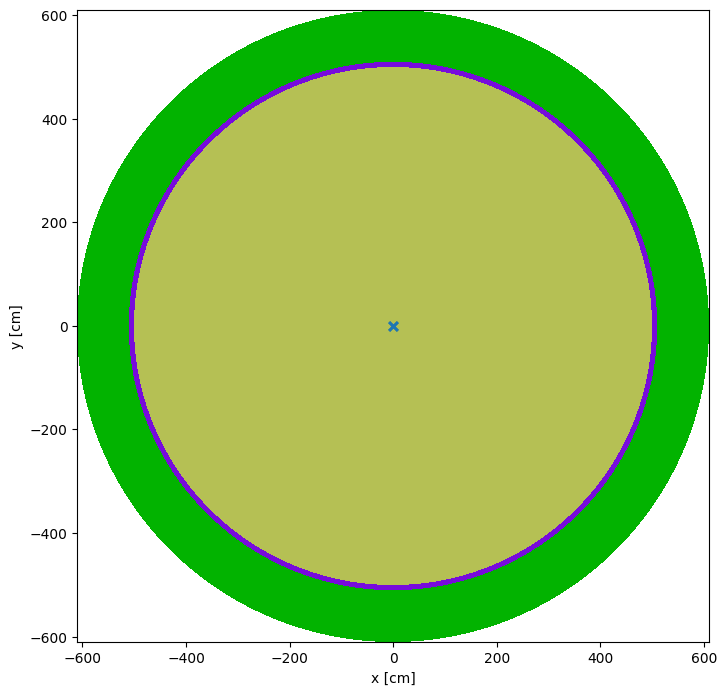

In [3]:
model = openmc.Model(my_geometry, my_materials, my_settings, my_tallies)
model.plot(n_samples=10, pixels=400000)

The next code block runs the simulation.

In [4]:
# removes the old output files
!rm *.h5

# Run OpenMC!
sp_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Finally, this code block loads up the output file and extracts the simulation result.

In [5]:
# open the results file
sp = openmc.StatePoint(sp_filename)

# access the tally using pandas dataframes
tbr_tally = sp.get_tally(name='TBR')
df = tbr_tally.get_pandas_dataframe()

# prints the contents of the dataframe
df

,cell,nuclide,score,mean,std. dev.
0,3,Li6,"(n,Xt)",1.022777,0.018036
1,3,Li7,"(n,Xt)",0.003777,0.000164


We can access the values from the dataframe

In [6]:
# sums up all the values in the mean column
tbr_tally_result = df['mean'].sum()

# sums up all the values in the std. dev. column
tbr_tally_std_dev = df['std. dev.'].sum()

# print the results
print('The tritium breeding ratio was found, TBR = ', tbr_tally_result)
print('Standard deviation on the tbr tally is ', tbr_tally_std_dev)

The tritium breeding ratio was found, TBR =  1.026554366872368
Standard deviation on the tbr tally is  0.01819989682075807


We can also access the individual results of tritium production in each isotope. This is provided because we added ```.nucl

**Learning Outcomes for Part 1:**

- Running simple neutronics simulations with OpenMC and tallying TBR using a cell tally.

In [7]:
# gets the row that has li6 in the nuclide column and 
lithium_6_contribution = df[df['nuclide'] == 'Li6']['mean'].sum()

lithium_7_contribution = df[df['nuclide'] == 'Li7']['mean'].sum()

print('The tritium breeding by lithium 6 is ', lithium_6_contribution)
print('The tritium breeding by lithium 7 is ', lithium_7_contribution)

The tritium breeding by lithium 6 is  1.0227773695941482
The tritium breeding by lithium 7 is  0.0037769972782197908


**Learning Outcomes for Part 1:**

- Running simple neutronics simulations with OpenMC and tallying TBR using a cell tally.
- Identify the which lithium isotope makes the majority of tritium production